In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
% cd "/content/drive/MyDrive/Norse SNN/Speach/"
% ls

/content/drive/MyDrive/Norse SNN/Speach
 checkpoints/                   'Копия CNN ASR.ipynb'
'code 19_45 check point.ipynb'  'Копия code 3conv zeros.ipynb'
'code 3conv zeros.ipynb'        'Копия code.ipynb'
 data/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
from collections import Counter


import torch
import torch.nn as nn 
import torch.nn.functional as F

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets


from tqdm.notebook import tqdm
from time import time



In [ ]:
# Check whether a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("selected device: ", device)

selected device:  cuda


In [ ]:
def load_split_train_test(datadir, valid_size = .2, batch_size=1):
    print('batch_size', batch_size)
    train_transforms = transforms.Compose([transforms.Resize(28),
                                           transforms.ToTensor(),
                                           #transforms.Lambda(lambda d: torch.reshape(d[1,:,:], (1, d.shape[1], d.shape[2]) ))
                                          ])
    test_transforms = transforms.Compose([transforms.Resize(28),
                                          transforms.ToTensor(),
                                          #transforms.Lambda(lambda d: torch.reshape(d[1,:,:], (1, d.shape[1], d.shape[2]) ))
                                         ])

    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)


    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)
                   
    return trainloader, testloader

In [ ]:
def evalute(model, test_loader):
    print('\nTest model')
    correct = 0
    total = 0
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, target in tqdm(test_loader):
          
            out = model(img.to(device))
            
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)


    return 100*correct / total

In [ ]:
def train_test_loop(model, train_loader, test_loader, opt = 'SGD', EPOCH = 1, lr = 0.01, momentum=0.9 ):
    print('Train model')
    
    if opt == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4)
    elif opt == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
      print('Unknown optim', opt)


    model.to(device)

    best_acc = evalute(model, test_loader)
    print('\nAccuracy now: ', best_acc)
    
    for epoch in range(1,EPOCH+1):
        print("\nEpoch %d/%d"%(epoch, EPOCH))
        model.train()
        for img, target in tqdm(train_loader):
            img, target = img.to(device), target.to(device)

            optimizer.zero_grad()

            out = model(img)

            loss = F.cross_entropy(out, target)
            loss.backward()

            optimizer.step()



        model.eval()
        acc = evalute(model, test_loader)
        print("Accuracy: ", acc)

        if best_acc < acc:
          print('Save', best_acc,'-->', acc)
          torch.save( model, './checkpoint/cnn.pth')
          best_acc = acc
          
        print()

    model = torch.load('./checkpoint/cnn.pth')
    print("\nBest Acc=%.4f"%(best_acc))

In [ ]:
dtype = torch.float32

train_loader, test_loader = load_split_train_test("./data/Russian_Speach_Digit_0-9 (spec, low)", .2, 40)

print('classes:', train_loader.dataset.classes)
print('train loader size:', len(train_loader))

batch_size 40
classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
train loader size: 200


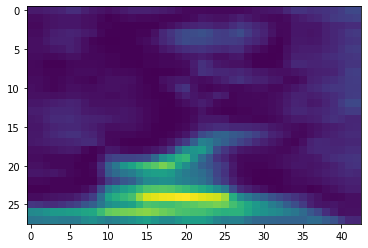

In [ ]:
plt.imshow(train_loader.dataset[5][0][0])

In [ ]:
class CNN(nn.Module):

  def __init__(self): 
         super(CNN, self).__init__() 
         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

         self.convlayer1 = nn.Sequential( 
                              nn.Conv2d(32, 64, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.convlayer2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.fclayer1 = nn.Sequential( 
                              nn.Linear(6720, 4096) , 
                              nn.Dropout(0.2) 
                              ) 
         
         self.fclayer2 = nn.Sequential( 
                              nn.Linear(4096, 2048) , 
                              nn.Dropout(0.2) 
                              ) 
            

         self.out = nn.Linear(2048, 10)

  def forward(self, x): 
         out = self.conv1(x) 
         out = self.convlayer1(out) 
         out = self.convlayer2(out) 
         out = out.reshape(out.size(0), -1) 
         #print(out.shape)

         out = self.fclayer1(out) 
         out = self.fclayer2(out) 

         return self.out(out)



In [ ]:
model = CNN()
print(model) 

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convlayer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fclayer1): Sequential(
    (0): Linear(in_features=6720, out_features=4096, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
  (fclayer2): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
  (out): Linear(in_features=2048, out_features=10, bias=True)
)


In [ ]:
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 10, lr = learning_rate)

Train model

Test model




Accuracy now:  9.679037111334003

Epoch 1/10




Test model



Accuracy:  99.04714142427282
Save 9.679037111334003 --> 99.04714142427282


FileNotFoundError: ignored

In [ ]:
torch.save( model, './checkpoints/cnn.pth')